In [16]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torch.cuda.amp as amp  

class HAM(nn.Module):
    def __init__(self, in_channels):
        super(HAM, self).__init__()
        self.conv_s = nn.Conv2d(2, 1, kernel_size=7, padding=3)
        self.fc1 = nn.Linear(in_channels, in_channels // 16)
        self.fc2 = nn.Linear(in_channels // 16, in_channels)

    def forward(self, x):
        max_pool = torch.max(x, dim=1, keepdim=True)[0]  
        avg_pool = torch.mean(x, dim=1, keepdim=True)    
        spatial_out = torch.cat([max_pool, avg_pool], dim=1)
        spatial_out = torch.sigmoid(self.conv_s(spatial_out))
        x = x * spatial_out
        
        avg_pool = x.mean(dim=(2, 3))  # [B, C]
        max_pool = torch.max(torch.max(x, dim=2)[0], dim=2)[0]
        channel_out = torch.sigmoid(self.fc2(F.relu(self.fc1(avg_pool + max_pool))))
        x = x * channel_out.view(-1, x.size(1), 1, 1)
        return x

class AttnCancerNet(nn.Module):
    def __init__(self, num_classes=2):
        super(AttnCancerNet, self).__init__()
        self.backbone = torch.hub.load('pytorch/vision:v0.10.0', 'resnet50', pretrained=True)
        self.backbone.conv1 = nn.Conv2d(1, 64, kernel_size=7, stride=2, padding=3, bias=False)
        
        self.conv_c2 = nn.Conv2d(256, 240, kernel_size=1)
        self.conv_c3 = nn.Conv2d(512, 240, kernel_size=1)
        self.conv_c4 = nn.Conv2d(1024, 240, kernel_size=1)
        self.conv_c5 = nn.Conv2d(2048, 240, kernel_size=1)
        
        self.mffm = nn.Conv2d(960, 256, kernel_size=1)
        self.ham = HAM(256)
        self.fc = nn.Sequential(
            nn.Linear(256, 64),
            nn.ReLU(),
            nn.Dropout(0.5),
            nn.Linear(64, num_classes)
        )

    def forward(self, x):
        c1 = self.backbone.conv1(x)
        c1 = self.backbone.bn1(c1)
        c1 = self.backbone.relu(c1)
        c1 = self.backbone.maxpool(c1)
        c2 = self.backbone.layer1(c1)
        c3 = self.backbone.layer2(c2)
        c4 = self.backbone.layer3(c3)
        c5 = self.backbone.layer4(c4)
        
        c2 = F.interpolate(c2, size=(14, 14), mode='bilinear', align_corners=False)
        c2 = self.conv_c2(c2)
        c3 = F.interpolate(c3, size=(14, 14), mode='bilinear', align_corners=False)
        c3 = self.conv_c3(c3)
        c4 = self.conv_c4(c4)
        c5 = F.interpolate(c5, size=(14, 14), mode='bilinear', align_corners=False)
        c5 = self.conv_c5(c5)
        
        fused = self.mffm(torch.cat([c2, c3, c4, c5], dim=1))
        attn_out = self.ham(fused)
        out = attn_out.mean(dim=(2, 3))
        out = self.fc(out)
        return out


class LIDCDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        self.root_dir = root_dir
        self.transform = transform
        self.samples = []
        
        for patient in os.listdir(root_dir):
            patient_path = os.path.join(root_dir, patient)
            for nodule in os.listdir(patient_path):
                nodule_path = os.path.join(patient_path, nodule)
                images_path = os.path.join(nodule_path, "images")
                slices = os.listdir(images_path)
                for slice_name in slices:
                    img_path = os.path.join(images_path, slice_name)
                    masks = [os.path.join(nodule_path, f"mask-{i}", slice_name) for i in range(4)]
                    mask_sum = 0
                    for mask_path in masks:
                        mask = np.array(Image.open(mask_path))
                        mask_sum += mask.sum()
                    label = 1 if mask_sum > 0 else 0
                    self.samples.append((img_path, label))

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        img_path, label = self.samples[idx]
        img = Image.open(img_path).convert("L")
        if self.transform:
            img = self.transform(img)
        return img, label




Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Epoch [1/50], Loss: 0.0634
Validation Accuracy: 99.66%
Epoch [2/50], Loss: 0.0298
Validation Accuracy: 99.66%
Epoch [3/50], Loss: 0.0304
Validation Accuracy: 99.66%
Epoch [4/50], Loss: 0.0295
Validation Accuracy: 99.66%
Epoch [5/50], Loss: 0.0277
Validation Accuracy: 99.66%
Epoch [6/50], Loss: 0.0293
Validation Accuracy: 99.66%
Epoch [7/50], Loss: 0.0263
Validation Accuracy: 99.66%
Epoch [8/50], Loss: 0.0271
Validation Accuracy: 99.66%
Epoch [9/50], Loss: 0.0255
Validation Accuracy: 99.66%
Epoch [10/50], Loss: 0.0248
Validation Accuracy: 99.66%
Epoch [11/50], Loss: 0.0219
Validation Accuracy: 99.66%
Epoch [12/50], Loss: 0.0225
Validation Accuracy: 99.66%
Epoch [13/50], Loss: 0.0204
Validation Accuracy: 99.66%
Epoch [14/50], Loss: 0.0199
Validation Accuracy: 99.66%
Epoch [15/50], Loss: 0.0192
Validation Accuracy: 99.70%
Epoch [16/50], Loss: 0.0183
Validation Accuracy: 99.74%
Epoch [17/50], Loss: 0.0168
Validation Accuracy: 99.66%
Epoch [18/50], Loss: 0.0165
Validation Accuracy: 99.66%
E

<ipython-input-17-c6e42dff2a3f>:99: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))


Test Accuracy: 99.66%


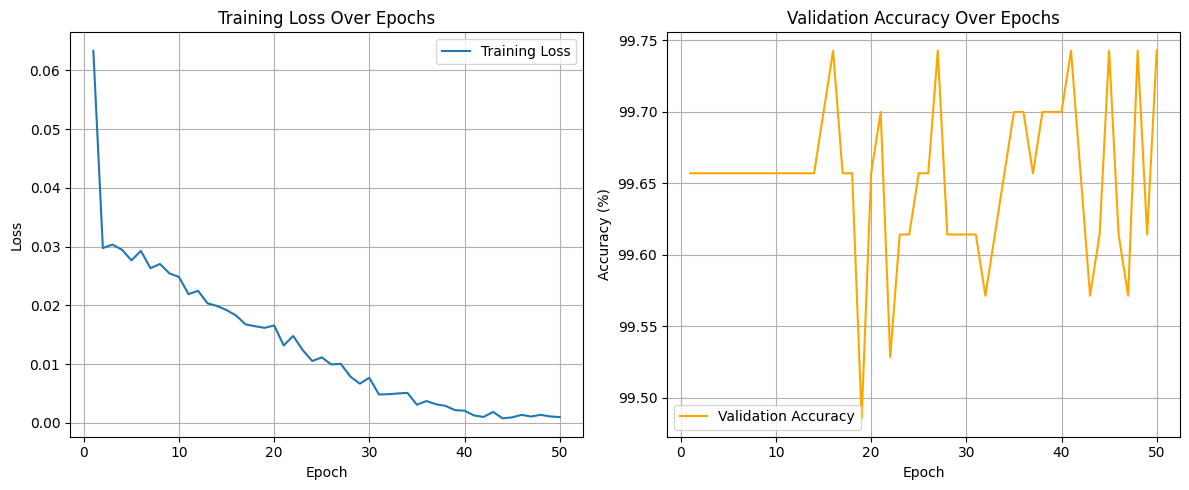

In [17]:
import os
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, Subset
from torchvision import transforms
from PIL import Image
import numpy as np
from sklearn.model_selection import train_test_split
import torch.cuda.amp as amp  
import matplotlib.pyplot as plt


transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.RandomHorizontalFlip(),
    transforms.RandomRotation(10),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5], std=[0.5])
])

root_dir = "/kaggle/input/lidcidri/LIDC-IDRI-slices"
dataset = LIDCDataset(root_dir, transform=transform)

# Split dataset
indices = list(range(len(dataset)))
train_idx, temp_idx = train_test_split(indices, test_size=0.3, random_state=42)
val_idx, test_idx = train_test_split(temp_idx, test_size=0.5, random_state=42)

train_dataset = Subset(dataset, train_idx)
val_dataset = Subset(dataset, val_idx)
test_dataset = Subset(dataset, test_idx)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=4, pin_memory=True)


device = torch.device("cuda")
model = AttnCancerNet(num_classes=2).to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-2)
scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=50)
scaler = torch.amp.GradScaler('cuda')  

train_losses = []
val_accuracies = []
num_epochs = 50
best_acc = 0.0

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        
        optimizer.zero_grad()
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
            loss = criterion(outputs, labels)
        
        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()
        running_loss += loss.item()
    
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}")
    
    
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            with torch.amp.autocast(device_type='cuda'):
                outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    val_acc = 100 * correct / total
    val_accuracies.append(val_acc)
    print(f"Validation Accuracy: {val_acc:.2f}%")
    
    if val_acc > best_acc:
        best_acc = val_acc
        torch.save(model.state_dict(), "/kaggle/working/best_model.pth")
    
    scheduler.step()


model.load_state_dict(torch.load("/kaggle/working/best_model.pth"))
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        with torch.amp.autocast(device_type='cuda'):
            outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()

test_acc = 100 * correct / total
print(f"Test Accuracy: {test_acc:.2f}%")


plt.figure(figsize=(12, 5))


plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs + 1), train_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Over Epochs')
plt.legend()
plt.grid(True)

plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs + 1), val_accuracies, label='Validation Accuracy', color='orange')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.title('Validation Accuracy Over Epochs')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()